In [1]:
import pandas as pd
import numpy as np

# Carga de datos

In [138]:
import pickle

with open("./Datasets/China/X_train_China.pkl", "rb") as archivo:
    ppg_signals = pickle.load(archivo).values 

with open("./Datasets/China/y_train_China.pkl", "rb") as archivo:
    y_labels = pickle.load(archivo).squeeze()

print(type(ppg_signals), ppg_signals.shape)
print(type(y_labels), y_labels.shape)

<class 'numpy.ndarray'> (459, 2100)
<class 'pandas.core.series.Series'> (459,)


In [139]:
def moving_average(signal, window_size=50):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

# Convertir cada fila del DataFrame en un arreglo de NumPy y aplicar el suavizado
ppg_signals = np.array([moving_average(ppg_signal) for ppg_signal in ppg_signals])

# Normalización Min-Max
def normalize_min_max(signals):
    # Calcular mínimos y máximos por fila
    min_vals = np.min(signals, axis=1, keepdims=True)
    max_vals = np.max(signals, axis=1, keepdims=True)
    # Normalizar cada fila
    return (signals - min_vals) / (max_vals - min_vals)

ppg_signals = normalize_min_max(ppg_signals)

# Aplicar EMD a una señal de ejemplo

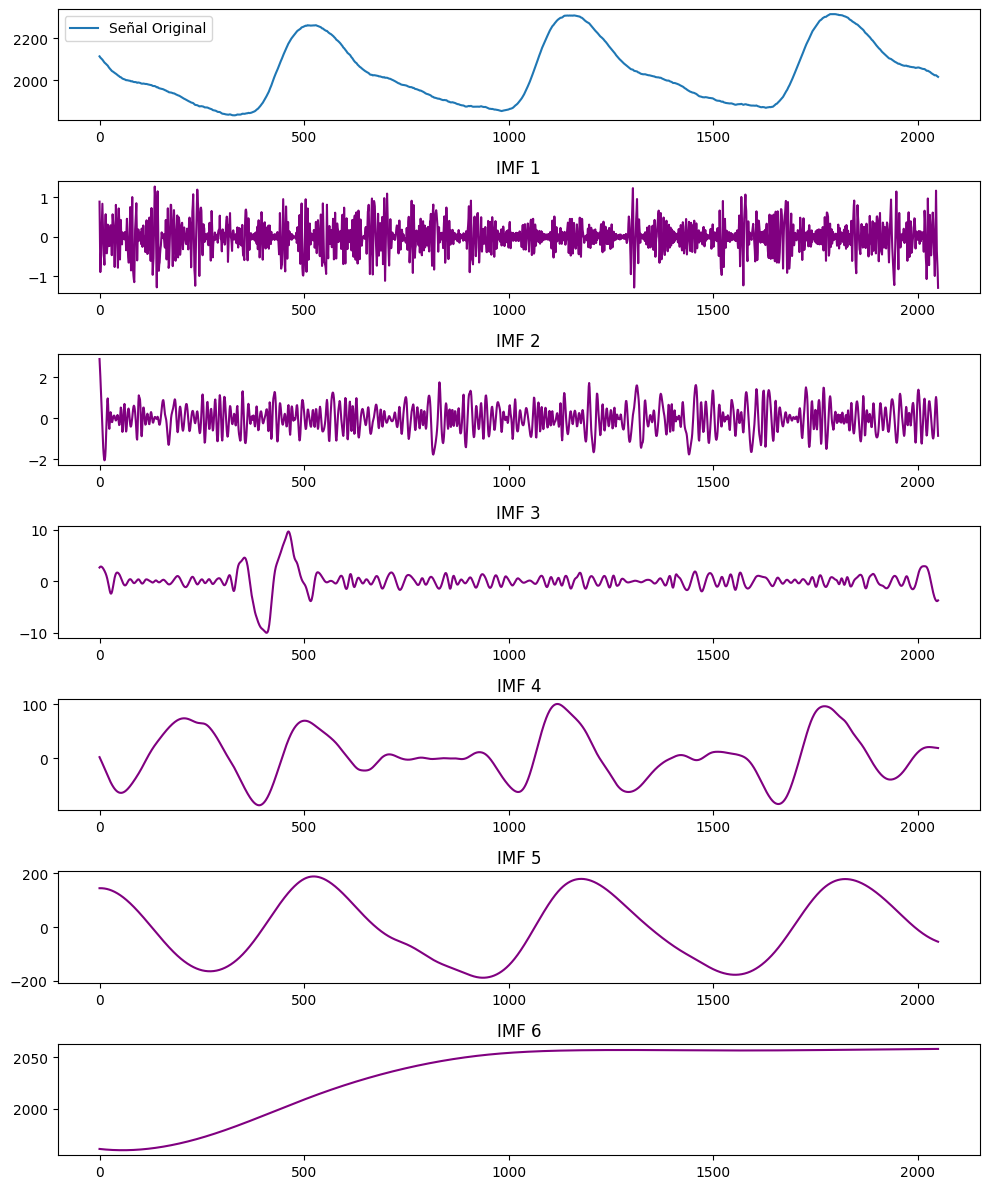

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD

# Seleccionamos una señal de ejemplo
idx = 1  
signal = ppg_signals[idx]  

# Aplicamos EMD
emd = EMD()
imfs = emd(signal)

# Visualizamos la señal original y sus IMFs
plt.figure(figsize=(10, len(imfs)*2))
plt.subplot(len(imfs) + 1, 1, 1)
plt.plot(signal, label="Señal Original")
plt.legend()

for i in range(len(imfs)):
    plt.subplot(len(imfs) + 1, 1, i + 2)
    plt.plot(imfs[i], color="purple")
    plt.title(f"IMF {i+1}")

plt.tight_layout()
plt.show()

# Aplicar EMD a todas las señales del conjunto

In [140]:
import numpy as np
import pandas as pd
from collections import defaultdict
from PyEMD import EMD  

num_frames, num_samples = ppg_signals.shape

# Configuración óptima encontrada
#fixe_value = 70
#fixe_h_value = 1
#max_iterations = 100  # Número máximo de iteraciones

# Diccionario para contar cuántas señales tienen cierta cantidad de IMFs
imf_counts = defaultdict(list)  # {num_imfs: [índices de señales]}

# Aplicamos EMD a cada señal y registramos cuántas IMFs genera
imf_list = []  # Para almacenar las IMFs de cada señal

for idx, signal in enumerate(ppg_signals):
    emd = EMD()
    
    # Ajustamos los parámetros de la EMD
    #emd.FIXE = fixe_value
    #emd.FIXE_H = fixe_h_value
    #emd.MAX_ITERATION = max_iterations

    # Ejecutamos la descomposición
    imfs = emd.emd(signal)
    
    # Guardamos el número de IMFs y su índice
    num_imfs = imfs.shape[0]
    imf_counts[num_imfs].append(idx)  # Asigna el índice de la señal a su cantidad de IMFs
    imf_list.append(imfs)  # Guardamos los IMFs para futuras visualizaciones

# Convertimos el diccionario en un DataFrame para visualizar mejor
imf_summary = pd.DataFrame([(k, len(v)) for k, v in imf_counts.items()], columns=["Num_IMFs", "Cantidad_Señales"])

# Ordenamos los datos por número de IMFs
imf_summary = imf_summary.sort_values(by="Num_IMFs")

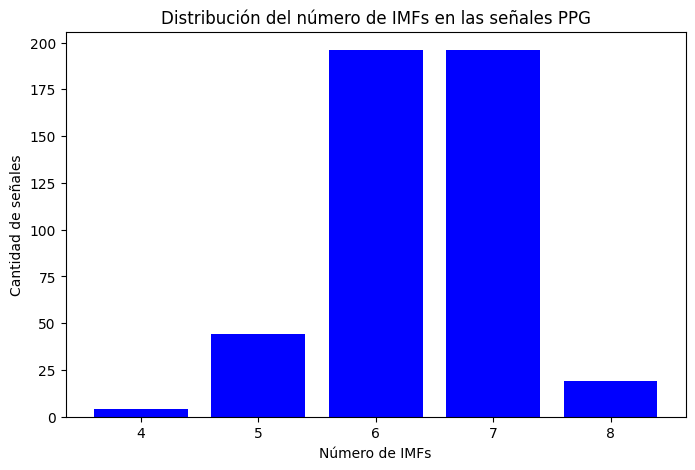

In [141]:
import matplotlib.pyplot as plt
# Visualizamos los resultados en un histograma
plt.figure(figsize=(8, 5))
plt.bar(imf_summary["Num_IMFs"], imf_summary["Cantidad_Señales"], color='blue')
plt.xlabel("Número de IMFs")
plt.ylabel("Cantidad de señales")
plt.title("Distribución del número de IMFs en las señales PPG")
plt.xticks(imf_summary["Num_IMFs"])
plt.show()

# Análisis frecuencial de las IMF

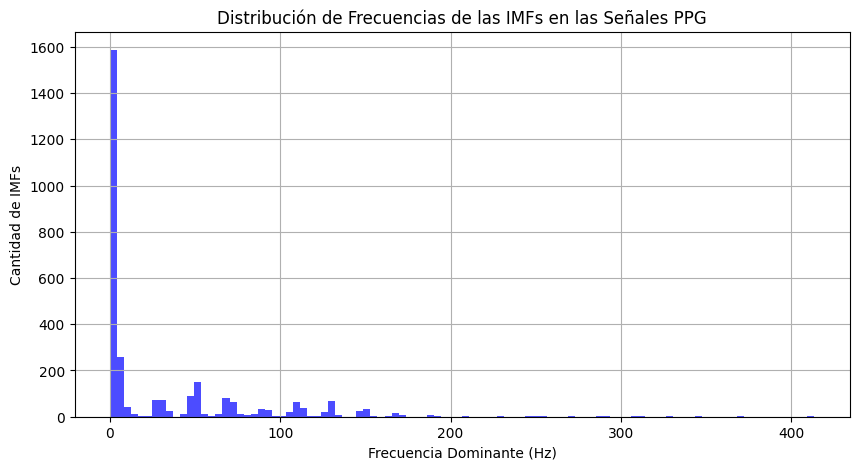

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq

# Parámetros de la señal
fs = 1000  # Frecuencia de muestreo (1 kHz)
n_samples = ppg_signals.shape[1] 
t = np.linspace(0, n_samples/fs, n_samples, endpoint=False)  # Vector de tiempo

# Lista para almacenar frecuencias de IMFs
imf_frequencies = []
signal_labels = []
imf_numbers = []

for idx in range(len(ppg_signals)):
    imfs = imf_list[idx]  # Extraemos las IMFs de la señal

    for i, imf in enumerate(imfs):
        # Aplicamos FFT a la IMF
        imf_fft = np.abs(fft(imf))[:n_samples // 2]
        freqs = fftfreq(n_samples, d=1/fs)[:n_samples // 2]

        # Frecuencia dominante
        dominant_freq = freqs[np.argmax(imf_fft)]

        # Guardamos los resultados
        imf_frequencies.append(dominant_freq)
        signal_labels.append(idx)
        imf_numbers.append(i + 1)  # Número de IMF

# Convertimos en DataFrame para análisis
df_imfs = pd.DataFrame({"Señal": signal_labels, "IMF": imf_numbers, "Frecuencia": imf_frequencies})
avg_frequencies = df_imfs.groupby("Señal")["Frecuencia"].apply(list).to_dict()

# Visualizamos la distribución de frecuencias
plt.figure(figsize=(10, 5))
plt.hist(imf_frequencies, bins=100, color='blue', alpha=0.7)
plt.xlabel("Frecuencia Dominante (Hz)")
plt.ylabel("Cantidad de IMFs")
plt.title("Distribución de Frecuencias de las IMFs en las Señales PPG")
plt.grid()
plt.show()

## Funciones para graficar el espectro con cluster agrupados (K-means) y recomposicion de las IMF de las señales

In [11]:
import seaborn as sns
from sklearn.cluster import KMeans

def calculate_adjusted_ranges_with_clustering_and_limits(
    avg_frequencies, num_clusters=5, frequency_limits=(0.25, 4)
):
    """
    Calcula rangos de frecuencia ajustados con clustering dentro de límites definidos.

    Parameters:
        avg_frequencies: Diccionario {signal_index: [frecuencias promedio de IMFs]}.
        num_clusters: Número de clusters (rangos) dentro del límite definido.
        frequency_limits: Tupla (min_limit, max_limit) con los límites para el clustering.

    Returns:
        adjusted_ranges: Lista de tuplas (min, max) con los rangos ajustados.
        all_frequencies: Lista de todas las frecuencias sin ceros.
        below_limit: Frecuencias por debajo del límite inferior.
        above_limit: Frecuencias por encima del límite superior.
    """
    min_limit, max_limit = frequency_limits

    # Convertir el diccionario en una lista de frecuencias, ignorando ceros
    all_frequencies = np.hstack([np.array(freqs) for freqs in avg_frequencies.values() if len(freqs) > 0])
    all_frequencies = all_frequencies[all_frequencies > 0]  # Filtrar ceros

    # Filtrar frecuencias fuera de los límites
    below_limit = all_frequencies[all_frequencies < min_limit]
    above_limit = all_frequencies[all_frequencies > max_limit]
    in_range_frequencies = all_frequencies[(all_frequencies >= min_limit) & (all_frequencies <= max_limit)]

    # Aplicar K-Means a las frecuencias dentro del rango
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(in_range_frequencies.reshape(-1, 1))
    centroids = np.sort(kmeans.cluster_centers_.flatten())

    # Generar rangos con los centroides
    adjusted_ranges = [(min_limit, centroids[0])]  # Primer rango desde min_limit
    for i in range(len(centroids) - 1):
        adjusted_ranges.append((centroids[i], centroids[i + 1]))
    adjusted_ranges.append((centroids[-1], max_limit))  # Último rango hasta max_limit

    # Agregar los rangos extremos
    adjusted_ranges = [(0, min_limit)] + adjusted_ranges + [(max_limit, np.inf)]

    return adjusted_ranges, all_frequencies, below_limit, above_limit


def plot_range_spectrum_with_limits(
    adjusted_ranges, all_frequencies, frequency_limits, xlim=(0, 1000), bins=100, ylim=(0,100)
):
    """
    Visualiza los rangos ajustados en el histograma con líneas de los límites definidos.

    Parameters:
        adjusted_ranges: Lista de rangos ajustados.
        all_frequencies: Lista de todas las frecuencias no nulas.
        frequency_limits: Tupla (min_limit, max_limit) con los límites del clustering.
        xlim: Tupla que define los límites del eje x.
        bins: Número de bins para el histograma.
    """
    plt.figure(figsize=(12, 5))
    colors = sns.color_palette("husl", len(adjusted_ranges))  # Asignar colores

    plt.hist(all_frequencies, bins=bins, color='skyblue', alpha=0.7, label='Frecuencias promedio')

    # Dibujar los límites definidos con líneas verticales
    min_limit, max_limit = frequency_limits
    plt.axvline(min_limit, color='red', linestyle='--', label=f'Límite inferior: {min_limit:.2f} Hz')
    plt.axvline(max_limit, color='red', linestyle='--', label=f'Límite superior: {max_limit:.2f} Hz')

    # Sombrear los rangos de frecuencia ajustados
    for i, (low, high) in enumerate(adjusted_ranges):
        if high < xlim[0] or low > xlim[1]:
            continue  # Ignorar rangos fuera del límite de visualización
        plt.axvspan(max(low, xlim[0]), min(high, xlim[1]), alpha=0.3, color=colors[i], label=f'Rango: {low:.2f}-{high:.2f}')

    plt.xlabel("Frecuencia promedio (Hz)")
    plt.xlim(xlim)  # Ajustar límites del eje x
    #plt.ylim(ylim)
    plt.xticks(np.linspace(xlim[0], xlim[1], num=16))  # Ajustar etiquetas del eje x
    plt.ylabel("Número de IMFs")
    plt.title("Rangos de frecuencia ajustados con límites definidos")
    plt.legend(loc="upper right", fontsize=8)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

def reorganize_and_fill_imfs(imfs_list, adjusted_ranges, frequencies):
    """
    Reorganiza y completa las IMFs de cada señal para que tengan un número fijo de IMFs.
    Calcula la frecuencia promedio de cada IMF, la asigna al rango correspondiente y organiza las IMFs.
    Si varias IMFs caen en el mismo rango, se suman. Si un rango no tiene IMFs, se rellena con ceros.

    Parameters:
        imfs_list: Lista de numpy arrays, donde cada array tiene las IMFs de una señal (n_imfs, n_samples).
        adjusted_ranges: Lista de tuplas (min, max) con los rangos de frecuencia ajustados.
        frequencies: Diccionario {signal_index: [frecuencias promedio de IMFs]}.

    Returns:
        reorganized_imfs: numpy array de forma (n_signals, num_ranges + 1, n_samples) con las IMFs reorganizadas.
                          El índice 0 corresponde a la componente residual o base.
    """
    num_ranges = len(adjusted_ranges)  # Número de rangos fijos
    n_signals = len(imfs_list)  # Número de señales
    n_samples = imfs_list[0].shape[1]  # Número de muestras por señal

    # Inicializar la matriz reorganizada con ceros (incluye un rango adicional para la tendencia/base en el índice 0)
    reorganized_imfs = np.zeros((n_signals, num_ranges + 1, n_samples))

    for signal_idx, (signal_imfs, signal_freqs) in enumerate(zip(imfs_list, frequencies.values())):
        for imf, freq in zip(signal_imfs, signal_freqs):
            # Encontrar el rango correspondiente para la IMF actual
            assigned = False
            for i, (low, high) in enumerate(adjusted_ranges):
                if low < freq <= high:
                    reorganized_imfs[signal_idx, i + 1, :] += imf  # Sumar la IMF al rango correspondiente
                    assigned = True
                    break

                
            # Si no se asignó a ningún rango, se considera parte de la componente base
            if not assigned:
                reorganized_imfs[signal_idx, 0, :] += imf

    return reorganized_imfs



def plot_reorganized_imfs(signal_indices, original_signals, reorganized_imfs, adjusted_ranges):
    """
    Grafica señales originales y sus IMFs reorganizadas con colores según el rango de frecuencia.

    Parámetros:
        signal_indices: Lista de índices de señales a graficar.
        original_signals: Lista o array con las señales originales.
        reorganized_imfs: Array (n_signals, num_ranges + 1, n_samples) con las IMFs reorganizadas.
                          El índice 0 corresponde a la componente residual o base.
        adjusted_ranges: Lista de tuplas con los rangos de frecuencia [(min, max)].
    """
    num_signals = len(signal_indices)
    num_imfs = reorganized_imfs.shape[1]  # Número de IMFs reorganizadas

    fig, axes = plt.subplots(num_signals, num_imfs + 2, figsize=(30, 3 * num_signals), sharex=True)

    # Definir colores para cada rango de frecuencia
    colors = sns.color_palette("husl", num_imfs - 1)

    for i, signal_idx in enumerate(signal_indices):
        # Gráfico de la señal original
        axes[i, 0].plot(original_signals[signal_idx], color="black", label=f"Señal Original - Índice {signal_idx}")
        axes[i, 0].legend(loc="upper left", fontsize=10, frameon=True)

        # Graficamos la componente residual o base
        axes[i, 1].plot(reorganized_imfs[signal_idx, 0, :], color="purple", label="Componente Residual/Base")
        axes[i, 1].legend(loc="upper left", fontsize=10, frameon=True)

        # Graficamos las IMFs reorganizadas con el color correspondiente al rango de frecuencia
        for j in range(1, num_imfs):
            axes[i, j + 1].plot(reorganized_imfs[signal_idx, j, :], color=colors[j - 1], label=f"IMF {j}\n({adjusted_ranges[j - 1][0]:.2f}-{adjusted_ranges[j - 1][1]:.2f} Hz)")
            axes[i, j + 1].legend(loc="upper left", fontsize=10, frameon=True)

        # Señal reconstruida sumando las IMFs reorganizadas
        reconstructed_signal = np.sum(reorganized_imfs[signal_idx], axis=0)
        axes[i, -1].plot(reconstructed_signal, color="red", label=f"Señal Reconstruida - Índice {signal_idx}")
        axes[i, -1].legend(loc="upper left", fontsize=10, frameon=True)

    plt.tight_layout()
    plt.show()


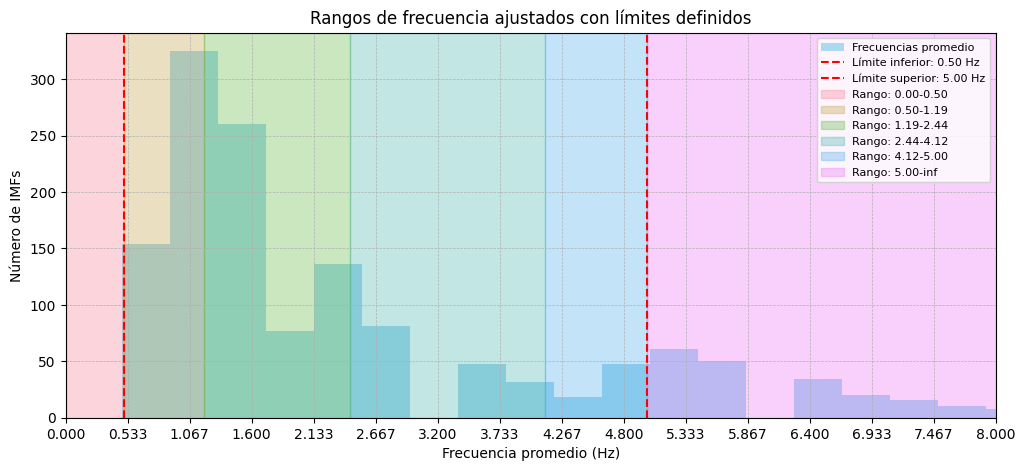

In [143]:
# Parámetros personalizados
frequency_limits = (0.5, 5)  # Definir el rango de aplicación de K-Means
num_clusters_fq = 3 # Ajustar el número de clusters

# Aplicar el clustering de frecuencias dentro del rango definido
adjusted_ranges_clustering, all_frequencies, below_limit, above_limit = calculate_adjusted_ranges_with_clustering_and_limits(
    avg_frequencies, num_clusters=num_clusters_fq, frequency_limits=frequency_limits
)

# Graficar los nuevos rangos de frecuencia ajustados
plot_range_spectrum_with_limits(adjusted_ranges_clustering, all_frequencies, frequency_limits, xlim=(0, 8), bins=1000)

In [144]:
reorganized_imfs = reorganize_and_fill_imfs(imf_list, adjusted_ranges_clustering, avg_frequencies)

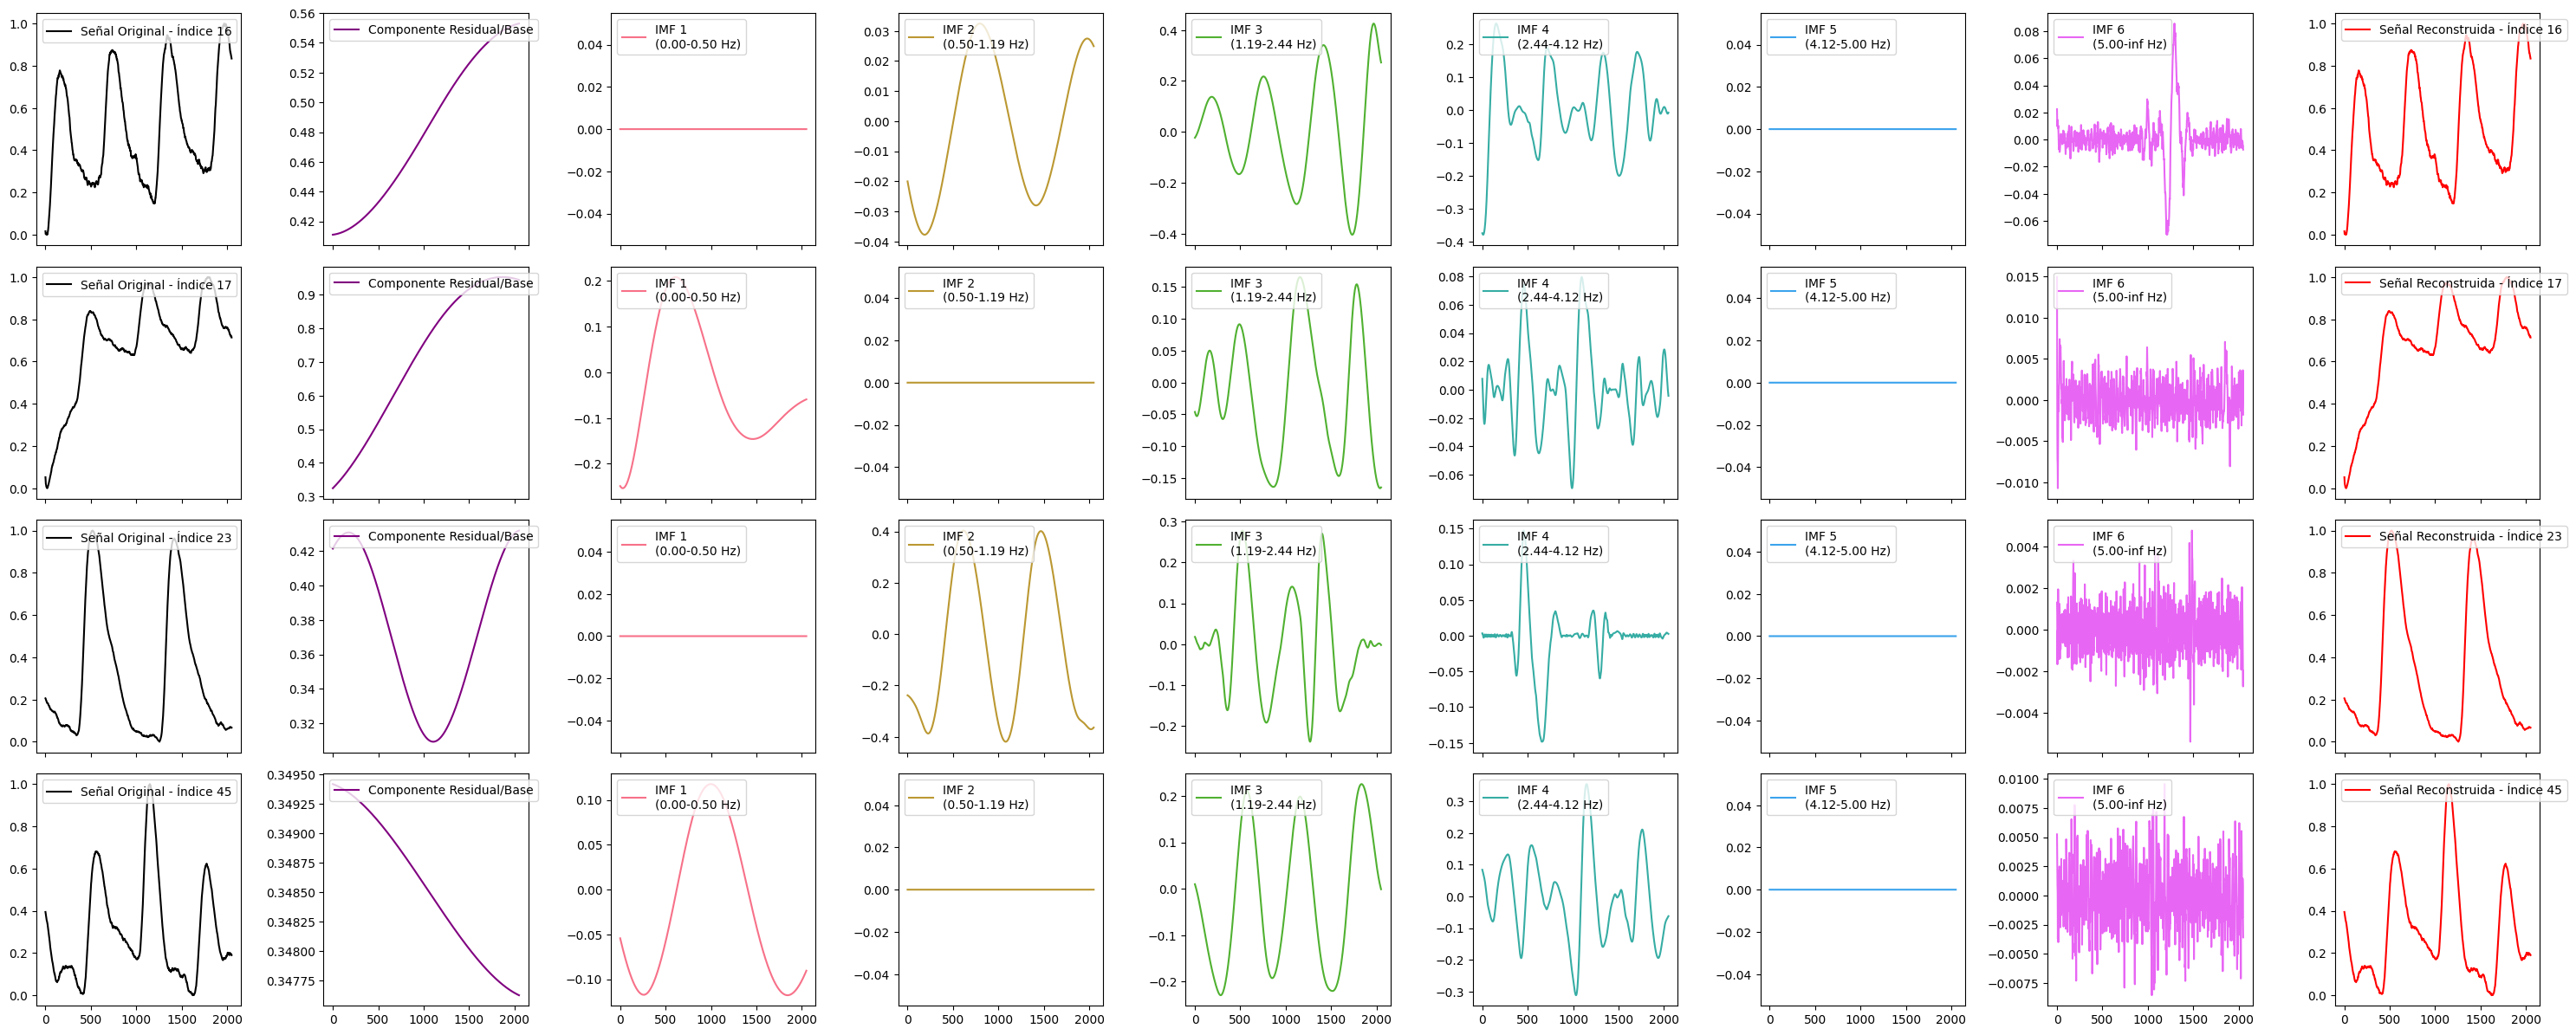

Señales con IMF en el índice 0: 459
Señales con IMF en el índice 1: 143
Señales con IMF en el índice 2: 270
Señales con IMF en el índice 3: 369
Señales con IMF en el índice 4: 151
Señales con IMF en el índice 5: 66
Señales con IMF en el índice 6: 459


In [145]:
selected_signal_indices = [16,17,23,45]  # Puedes cambiar los índices
plot_reorganized_imfs(selected_signal_indices, ppg_signals, reorganized_imfs, adjusted_ranges_clustering)
for i in range(reorganized_imfs.shape[1]):
    print(f"Señales con IMF en el índice {i}: {np.sum(np.any(reorganized_imfs[:, i, :] != 0, axis=1))}")

In [146]:
summed_imfs = reorganized_imfs.copy() 
summed_imfs[:,4,:] += summed_imfs[:,5,:] #Sumamos la IMF5 a la IMF 4
summed_imfs = np.delete(summed_imfs, 6, axis=1) #Eliminamos la IMF 6
summed_imfs = np.delete(summed_imfs, 5, axis=1) #Eliminamos la IMF 5

summed_imfs[:,1,:] += summed_imfs[:,0,:]
summed_imfs = np.delete(summed_imfs, 0, axis=1)

summed_imfs.shape

(459, 4, 2051)

In [147]:
adjusted_ranges_clustering

[(0, 0.5),
 (0.5, np.float64(1.1918305433663776)),
 (np.float64(1.1918305433663776), np.float64(2.4444687675167573)),
 (np.float64(2.4444687675167573), np.float64(4.120943342038297)),
 (np.float64(4.120943342038297), 5),
 (5, inf)]

In [148]:
adjusted_ranges_clustering_new = [(0, np.float64(1.1850931677018628)),
 (np.float64(1.1850931677018628), np.float64(2.405632984901277)),
 (np.float64(2.405632984901277), 5)]

In [149]:
# 🔹 Lista para almacenar los índices de señales sin ninguna IMF en cero
valid_signals = []

#for idx in similar_signals_indices:  # Iteramos sobre los índices seleccionados
for idx in range(len(summed_imfs)):
    if np.all(summed_imfs[idx] != 0):  # Verifica si TODAS las IMFs de la señal tienen valores distintos de 0
        valid_signals.append(idx)

# 🔹 Convertimos a un array numpy
valid_signals = np.array(valid_signals)

print(f"✅ Se han encontrado {len(valid_signals)} señales sin IMFs nulas.")
print(f"📌 Índices de señales seleccionadas: {valid_signals}")

✅ Se han encontrado 61 señales sin IMFs nulas.
📌 Índices de señales seleccionadas: [ 16  19  21  23  26  28  40  47  59  62  63  69  91  92  96 122 124 134
 137 142 144 146 158 164 165 167 179 188 190 209 235 238 242 249 250 264
 271 272 278 280 281 304 316 359 374 381 385 389 396 401 402 403 422 430
 432 433 434 440 452 456 458]


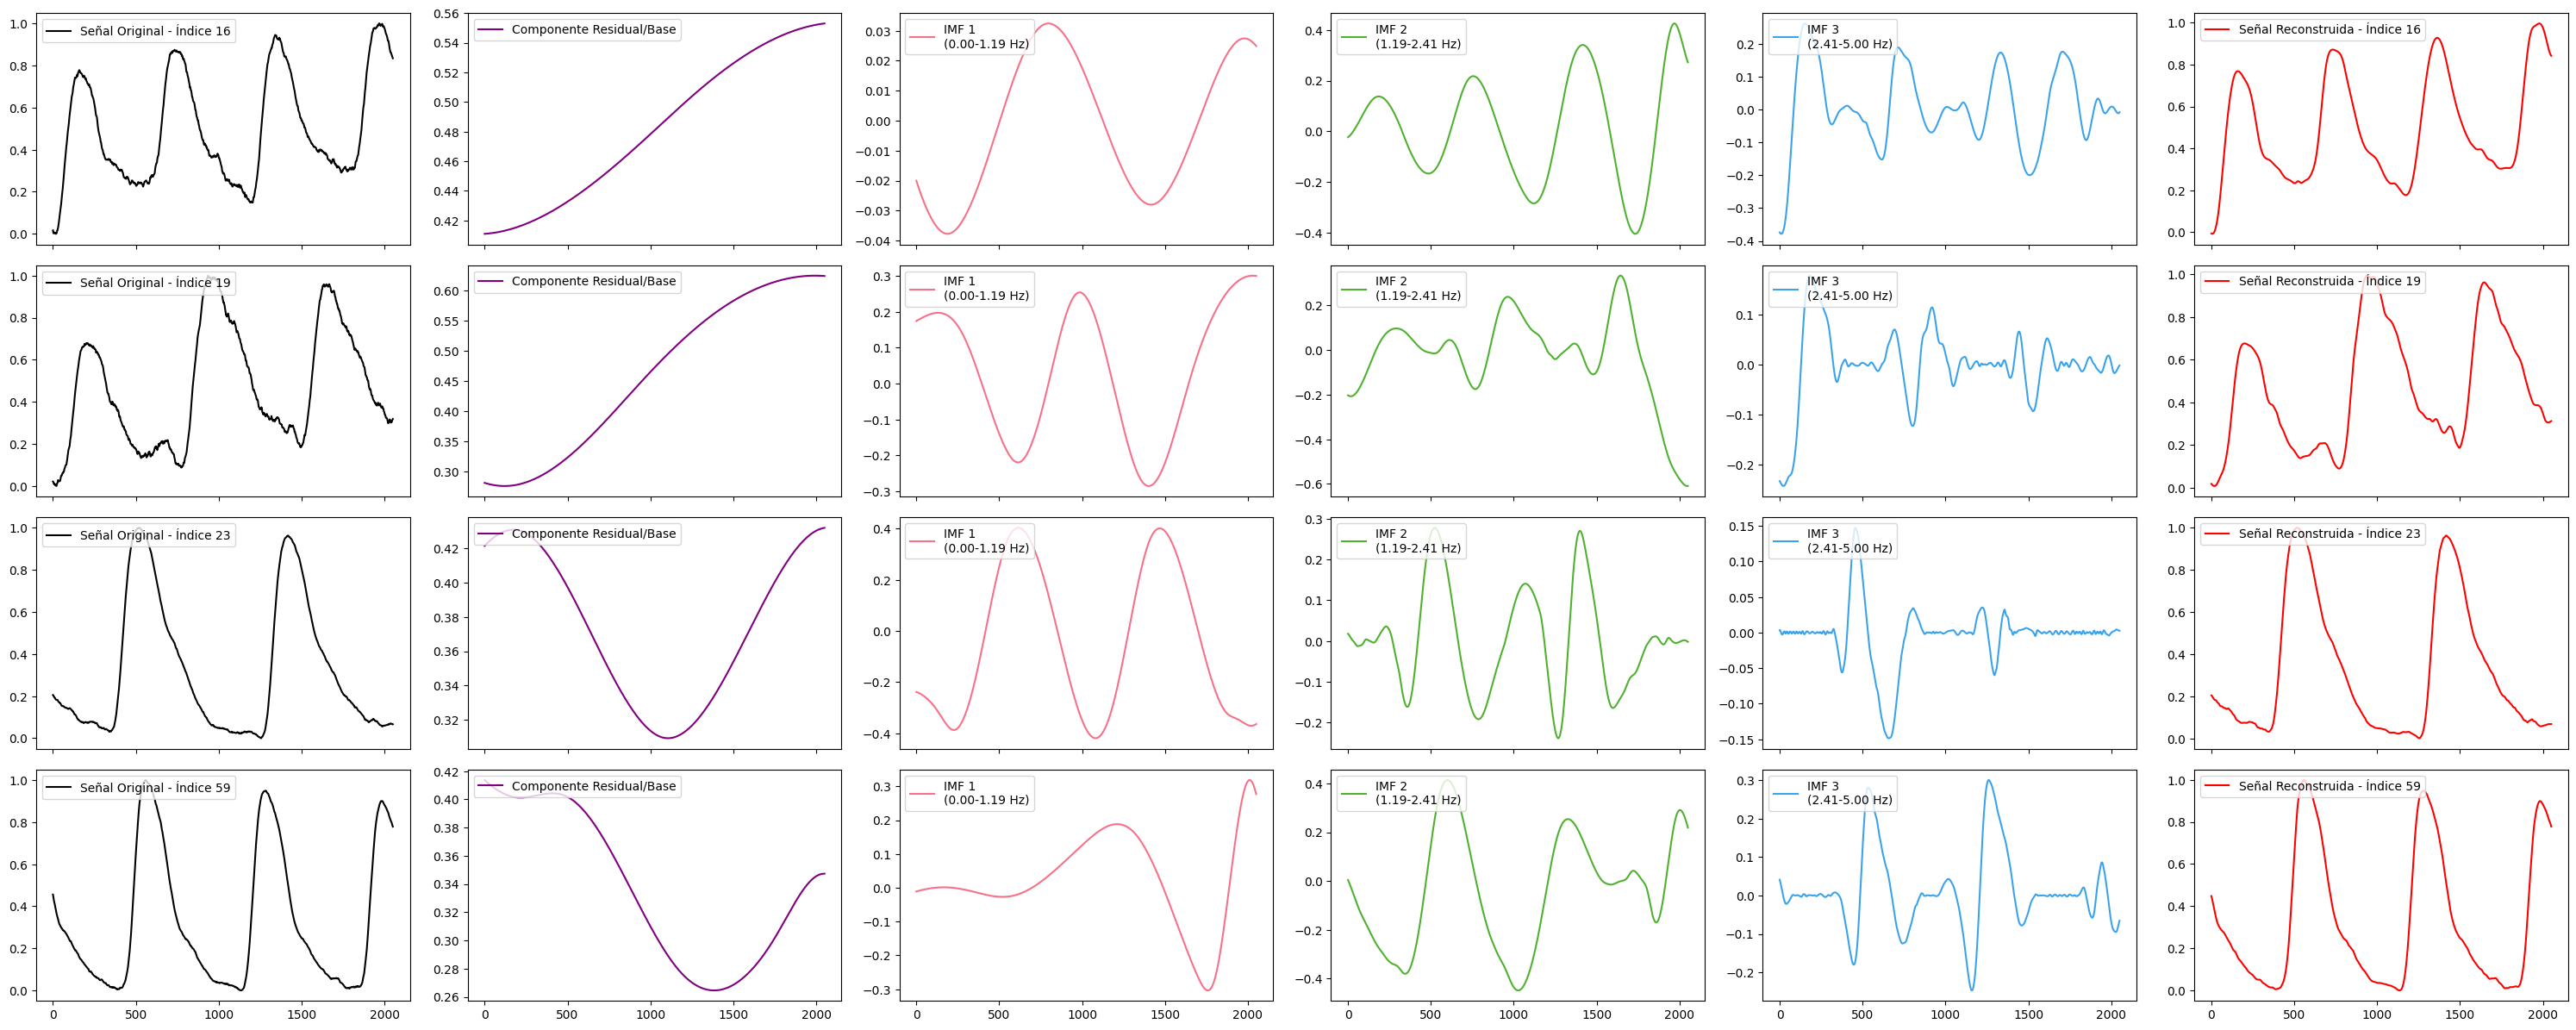

Señales con IMF en el índice 0: 459
Señales con IMF en el índice 1: 270
Señales con IMF en el índice 2: 369
Señales con IMF en el índice 3: 200


In [150]:
selected_signal_indices = [16,19,23,59]  # Puedes cambiar los índices
plot_reorganized_imfs(selected_signal_indices, ppg_signals, summed_imfs, adjusted_ranges_clustering_new)
for i in range(summed_imfs.shape[1]):
    print(f"Señales con IMF en el índice {i}: {np.sum(np.any(summed_imfs[:, i, :] != 0, axis=1))}")

# Data Augmentation

In [151]:
signals_imfs = summed_imfs
labels = y_labels
num_true = int(np.sum(labels))
num_false = len(labels) - num_true

print(f"✅ Número de True: {num_true}")
print(f"✅ Número de False: {num_false}")

✅ Número de True: 168
✅ Número de False: 291


In [129]:
def create_artificial_frame_v2(signals_imfs: np.array, labels: np.array, num_synthetic_per_class=[500, 500], set_real_IMFs_idx=None):
    """
    Genera señales sintéticas combinando IMFs de señales originales de la misma clase,
    evitando IMFs que sean completamente ceros y buscando reemplazo dentro de otra señal de la misma clase.

    Parámetros:
        signals_imfs: np.array de forma (num_signals, num_imfs, num_samples) con las IMFs de cada señal.
        labels: np.array (num_signals,) con True para señales normales y False para señales con patología.
        num_synthetic_per_class: Lista con el número de señales sintéticas a generar por cada clase.
        set_real_IMFs_idx: Lista de índices de IMFs a utilizar para generar las nuevas señales. Si es None, se usan todas.

    Retorna:
        synthetic_signals_normal, synthetic_labels_normal,
        synthetic_signals_pathology, synthetic_labels_pathology
    """
    num_signals, num_imfs, num_samples = signals_imfs.shape

    if set_real_IMFs_idx is None:
        set_real_IMFs_idx = list(range(num_imfs))  # Si no se especifica, se usan todas las IMFs

    # Separar índices de señales por clase
    normal_indices = np.where(labels == True)[0]
    pathology_indices = np.where(labels == False)[0]

    def generate_synthetic_signals(signal_indices, num_synthetic):
        num_real_signals = len(signal_indices)
        synthetic_signals = np.zeros((num_synthetic, num_samples))

        for idx_FRM in range(num_synthetic):
            max_arti_IMFs = len(set_real_IMFs_idx)
            item_FRM_IMFs = np.zeros((num_samples, max_arti_IMFs))

            # Generar una secuencia aleatoria de señales reales de la misma clase
            seq_FRMs_idx = np.random.choice(num_real_signals, size=max_arti_IMFs, replace=True)

            for idx_IMF in range(max_arti_IMFs):
                idx_IMF_real = set_real_IMFs_idx[idx_IMF]

                # Seleccionar la IMF de una señal aleatoria dentro de la misma clase
                attempts = 0  # Para evitar bucles infinitos
                while True:
                    idx_FRM_real = signal_indices[seq_FRMs_idx[idx_IMF]]  # Selecciona una nueva señal de la misma clase
                    selected_IMF = signals_imfs[idx_FRM_real, idx_IMF_real, :]

                    # Verificar si la IMF seleccionada no es completamente cero
                    if not np.all(selected_IMF == 0):
                        item_FRM_IMFs[:, idx_IMF] = selected_IMF
                        break  # Si la IMF es válida, se usa y se sale del bucle

                    # Si la IMF es cero, elige otra señal aleatoria dentro de la misma clase
                    attempts += 1
                    if attempts > 10:  # Para evitar bucles infinitos
                        break  
                    seq_FRMs_idx[idx_IMF] = np.random.choice(num_real_signals)  # Cambiar solo la señal, no el índice de IMF

            # Sumar las IMFs seleccionadas para formar la señal sintética
            synthetic_signals[idx_FRM, :] = np.sum(item_FRM_IMFs, axis=1)

        return synthetic_signals

    # Generar señales sintéticas para cada clase
    synthetic_signals_normal = generate_synthetic_signals(normal_indices, num_synthetic_per_class[0])
    synthetic_signals_pathology = generate_synthetic_signals(pathology_indices, num_synthetic_per_class[1])

    # Crear etiquetas para las señales sintéticas
    synthetic_labels_normal = np.ones(num_synthetic_per_class[0], dtype=bool)
    synthetic_labels_pathology = np.zeros(num_synthetic_per_class[1], dtype=bool)

    return synthetic_signals_normal, synthetic_labels_normal, synthetic_signals_pathology, synthetic_labels_pathology

In [152]:
# 🔹 Generamos señales sintéticas 
num_synthetic_per_class = [500,500] #[normal, patologia]
synthetic_signals_normal, synthetic_labels_normal, synthetic_signals_pathology, synthetic_labels_pathology = create_artificial_frame_v2(
    signals_imfs, labels, num_synthetic_per_class,set_real_IMFs_idx=None
)

In [153]:
# 🔹 Combinamos todos los datos sintéticos en un solo conjunto
synthetic_signals = np.concatenate([synthetic_signals_normal, synthetic_signals_pathology])
synthetic_labels = np.concatenate([synthetic_labels_normal, synthetic_labels_pathology])

# 🔹 Mostrar resultados
print(f"✅ Se generaron {len(synthetic_signals_normal)} señales sintéticas normales y {len(synthetic_signals_pathology)} con patología.")
print(f"Forma de synthetic_signals: {synthetic_signals.shape}")
print(f"Distribución de etiquetas sintéticas: {np.unique(synthetic_labels, return_counts=True)}")

✅ Se generaron 500 señales sintéticas normales y 500 con patología.
Forma de synthetic_signals: (1000, 2051)
Distribución de etiquetas sintéticas: (array([False,  True]), array([500, 500]))


In [154]:
# Convertir ppg_signals a NumPy para facilitar la concatenación
original_signals_np = ppg_signals
y_labels_np = y_labels.to_numpy()

# Concatenar señales sintéticas con el dataset original
updated_signals = np.vstack((original_signals_np, synthetic_signals))

# Concatenar etiquetas sintéticas con las etiquetas originales
updated_labels = np.hstack((y_labels_np, synthetic_labels))

# Convertir de vuelta a pandas DataFrame y Series
updated_signals_df = pd.DataFrame(updated_signals)
updated_labels_series = pd.Series(updated_labels, index=range(len(updated_labels)), name=y_labels.name)

# Mostrar información del nuevo dataset
print(f"✅ Dataset original: {ppg_signals.shape}")
print(f"✅ Dataset con señales sintéticas: {updated_signals_df.shape}")
print(f"✅ Etiquetas originales: {y_labels.shape}")
print(f"✅ Etiquetas con señales sintéticas: {updated_labels_series.shape}")
print(f"Distribución de clases en el dataset actualizado:\n{updated_labels_series.value_counts()}")

✅ Dataset original: (459, 2051)
✅ Dataset con señales sintéticas: (1459, 2051)
✅ Etiquetas originales: (459,)
✅ Etiquetas con señales sintéticas: (1459,)
Distribución de clases en el dataset actualizado:
0
False    791
True     668
Name: count, dtype: int64


# Visualización de muestras de señales sintéticas

In [155]:
def plot_original_vs_synthetic(ppg_original, synthetic_normal, synthetic_pathology, num_samples=5):
    """
    Visualiza señales PPG originales, señales sintéticas normales y con patología en 3 subplots.

    Parámetros:
        ppg_original: np.array de forma (num_signals, num_samples) con señales PPG originales.
        synthetic_normal: np.array de señales sintéticas normales.
        synthetic_pathology: np.array de señales sintéticas con patología.
        num_samples: Número de señales a mostrar en cada categoría.

    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True, sharey=True)

    # Seleccionar índices aleatorios de señales originales
    original_indices = np.random.choice(ppg_original.shape[0], num_samples, replace=False)
    synthetic_normal_indices = np.random.choice(synthetic_normal.shape[0], num_samples, replace=False)
    synthetic_pathology_indices = np.random.choice(synthetic_pathology.shape[0], num_samples, replace=False)

    # 🔹 Graficar señales originales
    for idx in original_indices:
        axes[0].plot(ppg_original[idx], alpha=0.7, label=f"Señal {idx}")
    axes[0].set_title("Señales PPG Originales")
    axes[0].legend(loc="upper right", fontsize=8)

    # 🔹 Graficar señales sintéticas normales
    for idx in synthetic_normal_indices:
        axes[1].plot(synthetic_normal[idx], alpha=0.7, linestyle="dashed", label=f"Artificial Normal {idx}")
    axes[1].set_title("Señales Sintéticas Normales")
    axes[1].legend(loc="upper right", fontsize=8)

    # 🔹 Graficar señales sintéticas con patología
    for idx in synthetic_pathology_indices:
        axes[2].plot(synthetic_pathology[idx], alpha=0.7, linestyle="dotted", label=f"Artificial Patología {idx}")
    axes[2].set_title("Señales Sintéticas con Patología")
    axes[2].legend(loc="upper right", fontsize=8)

    # Ajustar etiquetas y formato
    for ax in axes:
        ax.set_ylabel("Amplitud")
        ax.grid(True, linestyle="--", linewidth=0.5)
    
    axes[-1].set_xlabel("Muestras")
    plt.tight_layout()
    plt.show()


def plot_separate_signals(ppg_original, synthetic_normal, synthetic_pathology, num_samples=2):
    """
    Visualiza señales PPG originales, señales sintéticas normales y señales sintéticas con patología
    en subplots separados (2 de cada tipo, total 6 gráficos).

    Parámetros:
        ppg_original: np.array de forma (num_signals, num_samples) con señales PPG originales.
        synthetic_normal: np.array de señales sintéticas normales.
        synthetic_pathology: np.array de señales sintéticas con patología.
        num_samples: Número de señales a mostrar en cada categoría (total de 6 subplots).

    """
    fig, axes = plt.subplots(3, num_samples, figsize=(20, 8), sharex=True, sharey=True)

    # Seleccionar índices aleatorios de señales originales
    original_indices = np.random.choice(ppg_original.shape[0], num_samples, replace=False)
    synthetic_normal_indices = np.random.choice(synthetic_normal.shape[0], num_samples, replace=False)
    synthetic_pathology_indices = np.random.choice(synthetic_pathology.shape[0], num_samples, replace=False)

    # 🔹 Graficar señales originales
    for i, idx in enumerate(original_indices):
        axes[0, i].plot(ppg_original[idx], color="black", label=f"Original {idx}")
        axes[0, i].set_title(f"Original {idx}")
        axes[0, i].legend(loc="upper right", fontsize=8)

    # 🔹 Graficar señales sintéticas normales
    for i, idx in enumerate(synthetic_normal_indices):
        axes[1, i].plot(synthetic_normal[idx], color="blue", linestyle="dashed", label=f"Artificial Normal {idx}")
        axes[1, i].set_title(f"Artificial Normal {idx}")
        axes[1, i].legend(loc="upper right", fontsize=8)

    # 🔹 Graficar señales sintéticas con patología
    for i, idx in enumerate(synthetic_pathology_indices):
        axes[2, i].plot(synthetic_pathology[idx], color="red", linestyle="dotted", label=f"Artificial Patología {idx}")
        axes[2, i].set_title(f"Artificial Patología {idx}")
        axes[2, i].legend(loc="upper right", fontsize=8)

    # Ajustar etiquetas y formato
    for ax in axes[-1]:  # Última fila
        ax.set_xlabel("Muestras")
    
    for ax in axes[:, 0]:  # Primera columna
        ax.set_ylabel("Amplitud")

    plt.tight_layout()
    plt.show()

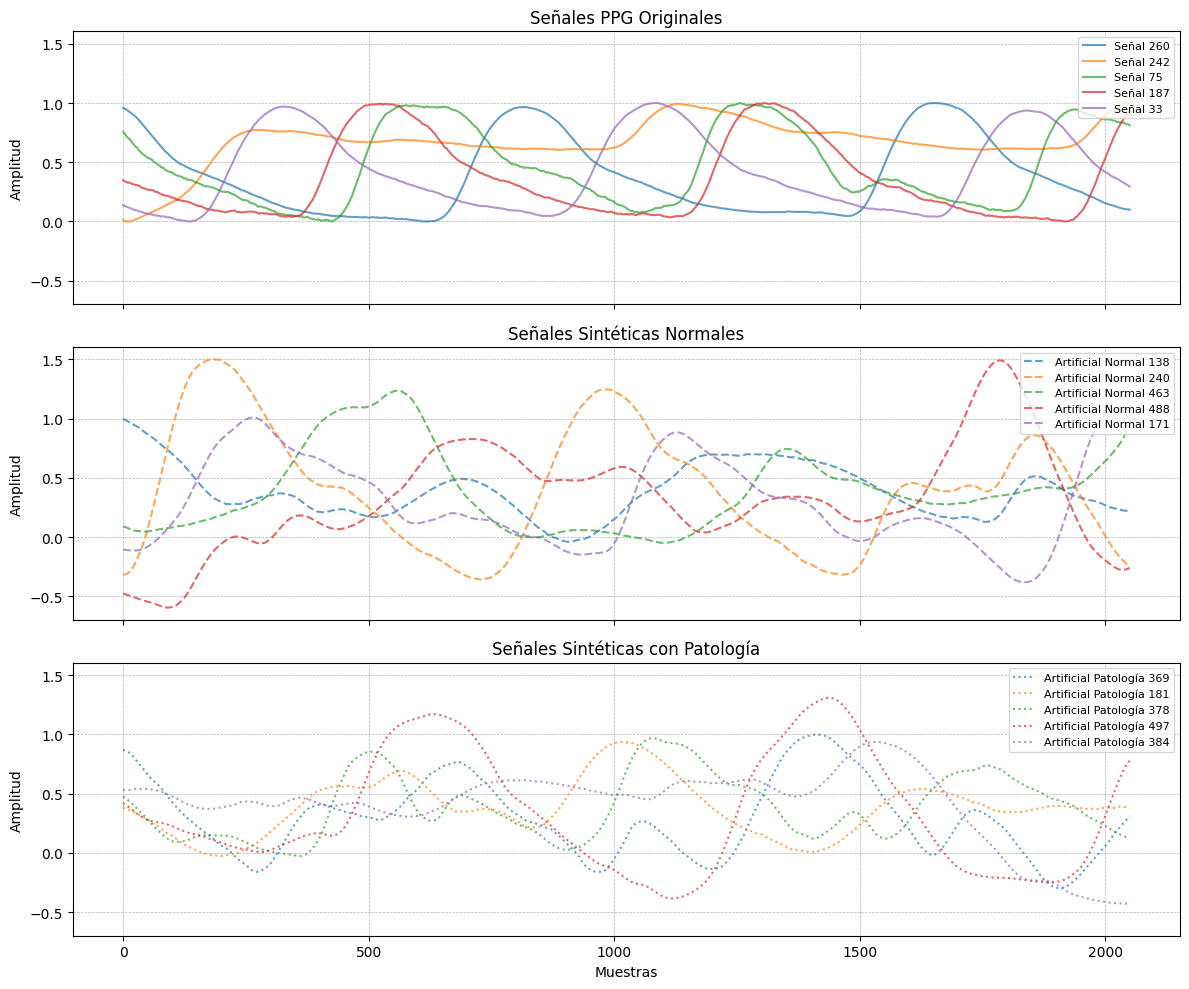

In [156]:
plot_original_vs_synthetic(ppg_signals, synthetic_signals_normal, synthetic_signals_pathology, num_samples=5)

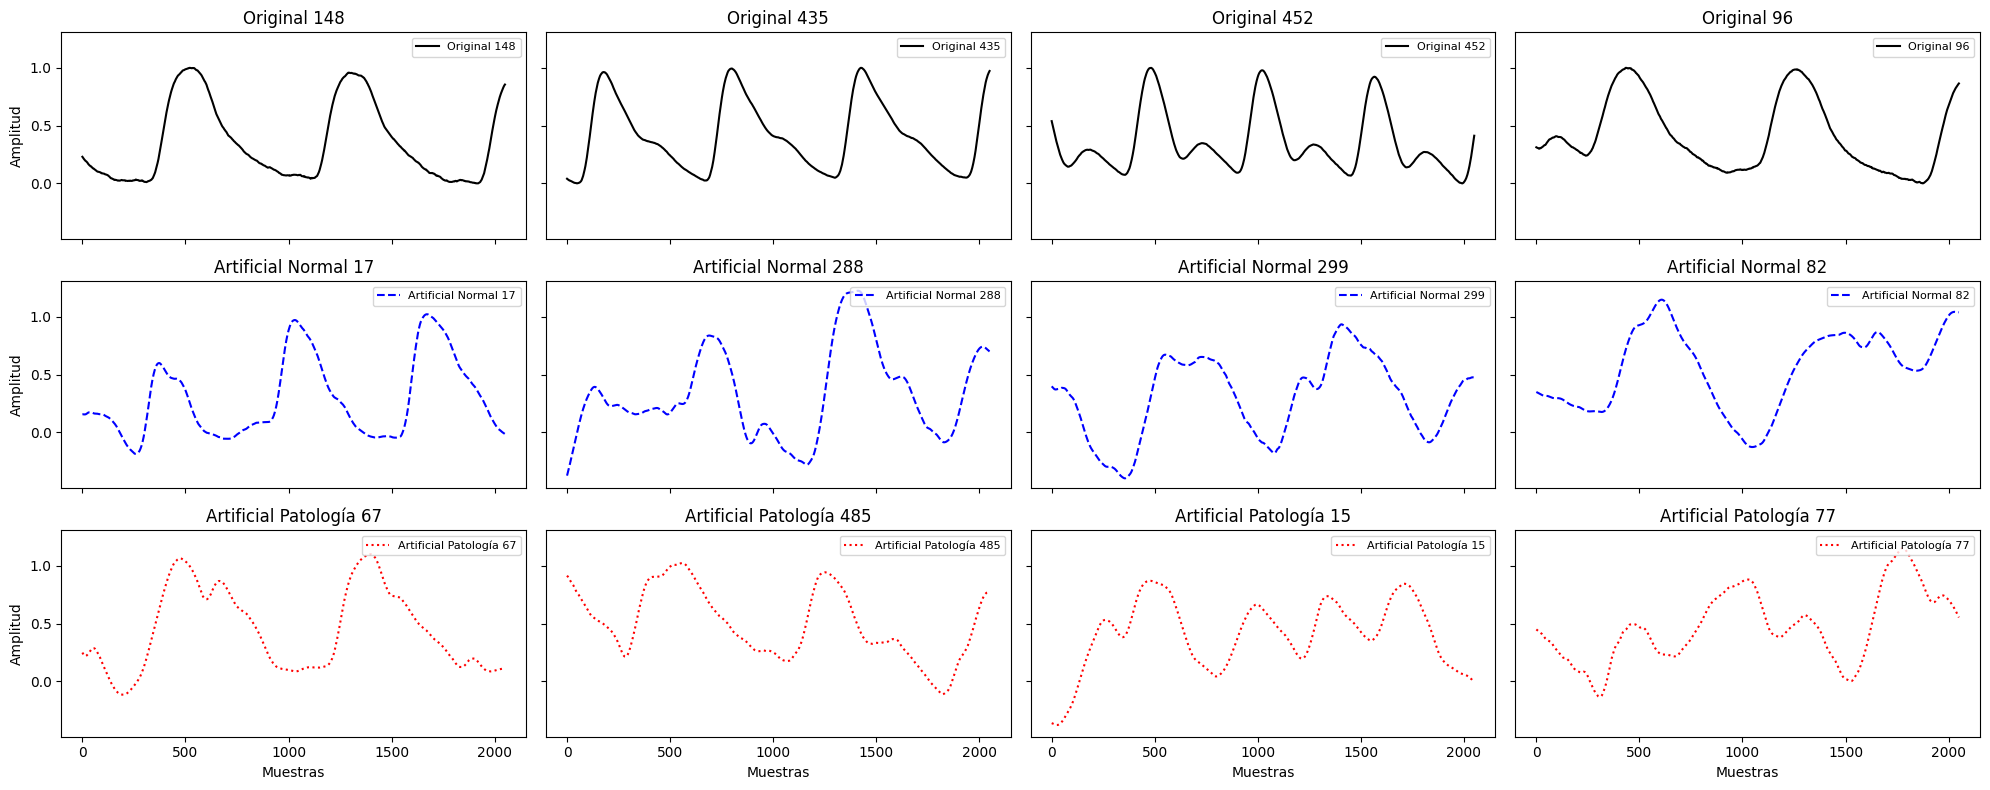

In [157]:
plot_separate_signals(ppg_signals, synthetic_signals_normal, synthetic_signals_pathology, num_samples=4)

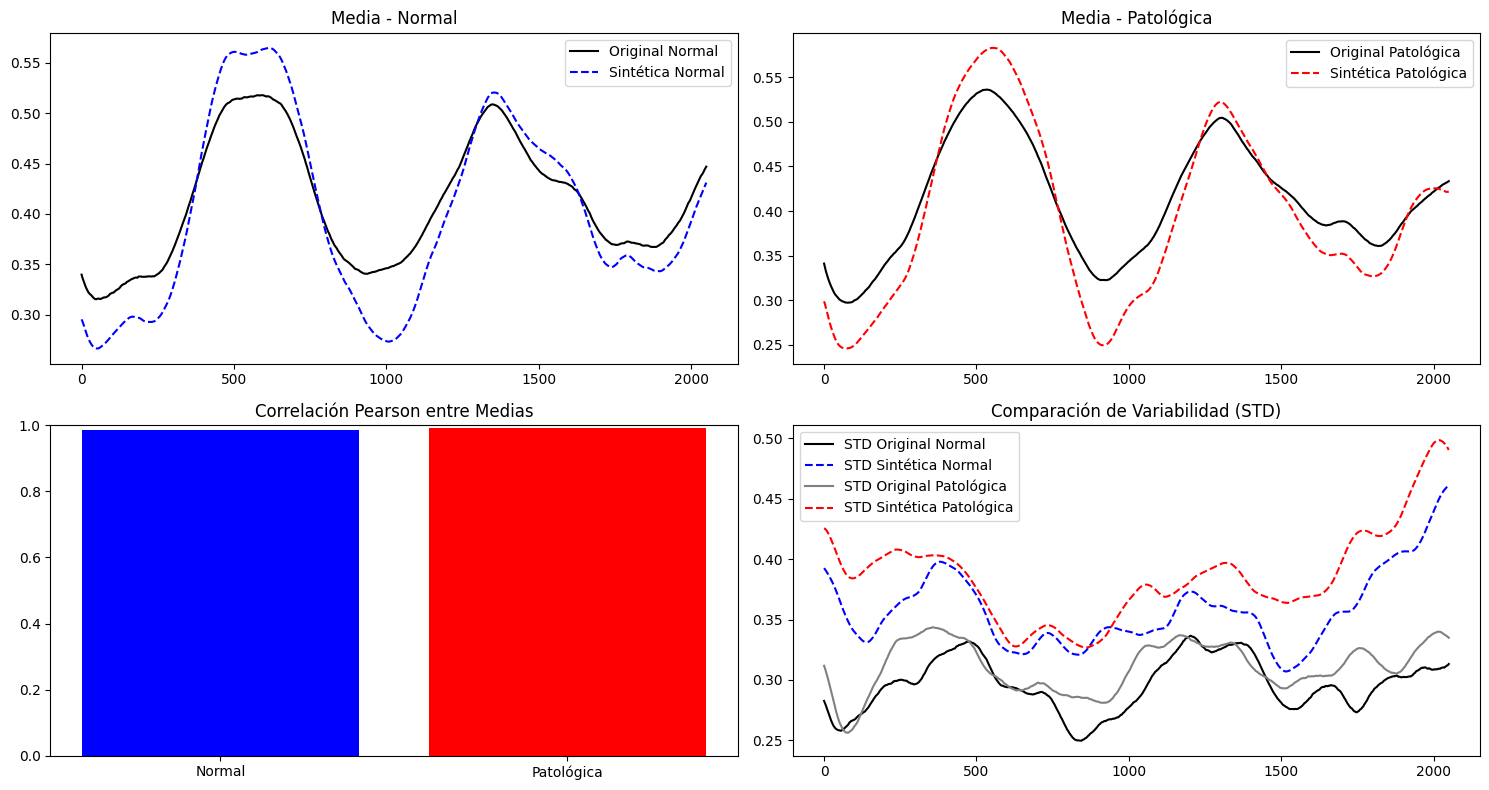

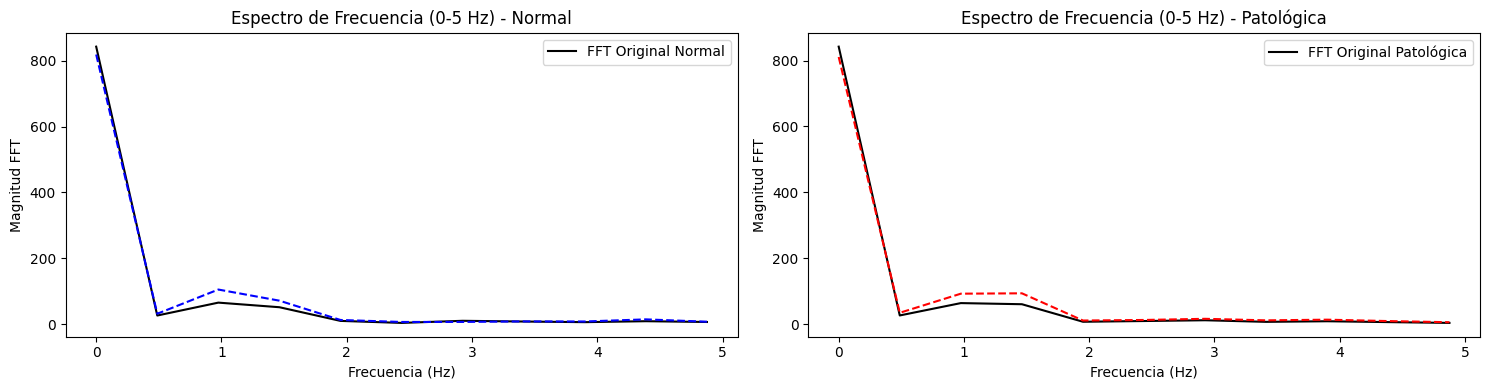

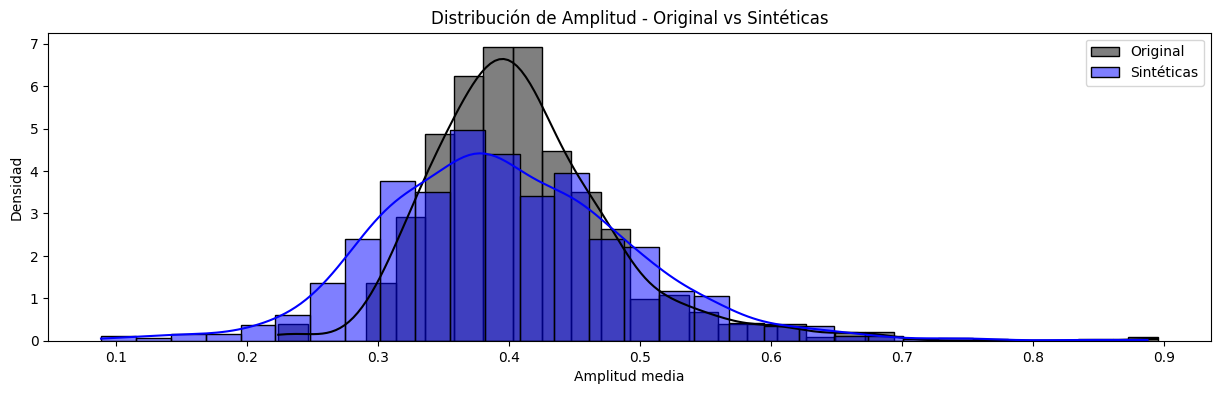

In [158]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.fftpack import fft
import seaborn as sns

y_labels_np = y_labels.to_numpy()
# Separar señales normales y patológicas según etiquetas
original_signals_normal = ppg_signals[y_labels_np == True]
original_signals_pathology = ppg_signals[y_labels_np == False]

synthetic_signals_normal = np.array(synthetic_signals_normal)
synthetic_signals_pathology = np.array(synthetic_signals_pathology)

# Número de muestras en cada señal
num_samples = original_signals_normal.shape[1]

# 1️⃣ **Promedio de señales por clase**
mean_original_normal = np.mean(original_signals_normal, axis=0)
mean_original_pathology = np.mean(original_signals_pathology, axis=0)
mean_synthetic_normal = np.mean(synthetic_signals_normal, axis=0)
mean_synthetic_pathology = np.mean(synthetic_signals_pathology, axis=0)

# 2️⃣ **Comparación visual de formas de onda representativas**
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

axes[0, 0].plot(mean_original_normal, label="Original Normal", color="black")
axes[0, 0].plot(mean_synthetic_normal, label="Sintética Normal", linestyle="dashed", color="blue")
axes[0, 0].set_title("Media - Normal")
axes[0, 0].legend()

axes[0, 1].plot(mean_original_pathology, label="Original Patológica", color="black")
axes[0, 1].plot(mean_synthetic_pathology, label="Sintética Patológica", linestyle="dashed", color="red")
axes[0, 1].set_title("Media - Patológica")
axes[0, 1].legend()

# 3️⃣ **Correlación entre señales originales y sintéticas**
corr_normal, _ = pearsonr(mean_original_normal, mean_synthetic_normal)
corr_pathology, _ = pearsonr(mean_original_pathology, mean_synthetic_pathology)

axes[1, 0].bar(["Normal", "Patológica"], [corr_normal, corr_pathology], color=["blue", "red"])
axes[1, 0].set_ylim(0, 1)
axes[1, 0].set_title("Correlación Pearson entre Medias")

# 4️⃣ **Análisis de variabilidad (Desviación estándar)**
std_original_normal = np.std(original_signals_normal, axis=0)
std_original_pathology = np.std(original_signals_pathology, axis=0)
std_synthetic_normal = np.std(synthetic_signals_normal, axis=0)
std_synthetic_pathology = np.std(synthetic_signals_pathology, axis=0)

axes[1, 1].plot(std_original_normal, label="STD Original Normal", color="black")
axes[1, 1].plot(std_synthetic_normal, label="STD Sintética Normal", linestyle="dashed", color="blue")
axes[1, 1].plot(std_original_pathology, label="STD Original Patológica", color="grey")
axes[1, 1].plot(std_synthetic_pathology, label="STD Sintética Patológica", linestyle="dashed", color="red")
axes[1, 1].set_title("Comparación de Variabilidad (STD)")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# 5️⃣ **Comparación de espectros de frecuencia (FFT) en el rango de 0-5 Hz**
freqs = np.fft.fftfreq(num_samples, d=1/1000)  # Asumiendo muestreo a 1 kHz
fft_original_normal = np.abs(fft(mean_original_normal))
fft_synthetic_normal = np.abs(fft(mean_synthetic_normal))
fft_original_pathology = np.abs(fft(mean_original_pathology))
fft_synthetic_pathology = np.abs(fft(mean_synthetic_pathology))

# Filtrar frecuencias entre 0 y 10 Hz
low_freq_mask = (freqs >= 0) & (freqs <= 5)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].plot(freqs[low_freq_mask], fft_original_normal[low_freq_mask], label="FFT Original Normal", color="black")
axes[0].plot(freqs[low_freq_mask], fft_synthetic_normal[low_freq_mask], linestyle="dashed", color="blue")
axes[0].set_title("Espectro de Frecuencia (0-5 Hz) - Normal")
axes[0].set_xlabel("Frecuencia (Hz)")
axes[0].set_ylabel("Magnitud FFT")
axes[0].legend()

axes[1].plot(freqs[low_freq_mask], fft_original_pathology[low_freq_mask], label="FFT Original Patológica", color="black")
axes[1].plot(freqs[low_freq_mask], fft_synthetic_pathology[low_freq_mask], linestyle="dashed", color="red")
axes[1].set_title("Espectro de Frecuencia (0-5 Hz) - Patológica")
axes[1].set_xlabel("Frecuencia (Hz)")
axes[1].set_ylabel("Magnitud FFT")
axes[1].legend()

plt.tight_layout()
plt.show()

# 6️⃣ **Distribución de amplitudes originales vs sintéticas**
mean_original = np.mean(original_signals_normal, axis=1).tolist() + np.mean(original_signals_pathology, axis=1).tolist()
mean_synthetic = np.mean(synthetic_signals_normal, axis=1).tolist() + np.mean(synthetic_signals_pathology, axis=1).tolist()

plt.figure(figsize=(15, 4))
sns.histplot(mean_original, bins=30, alpha=0.5, label="Original", color='black', kde=True, stat='density')
sns.histplot(mean_synthetic, bins=30, alpha=0.5, label="Sintéticas", color='blue', kde=True,stat='density')
plt.xlabel("Amplitud media")
plt.ylabel("Densidad")
#plt.ylim((0,500))
plt.legend()
plt.title("Distribución de Amplitud - Original vs Sintéticas")
plt.show()


In [159]:
# Guardar en un archivo
with open("./Datasets/China/X_train_China_Augmented.pkl", "wb") as archivo:
    pickle.dump(updated_signals_df.values, archivo)

with open("./Datasets/China/y_train_China_Augmented.pkl", "wb") as archivo:
    pickle.dump(updated_labels_series, archivo)